##Dependencies

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!pip install Sastrawi

In [ ]:
import pandas as pd
import string
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
import random
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

##Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset_Question.csv",sep=',')

In [ ]:
df

In [ ]:
question = df.Question
category = df.Class

In [ ]:
df.Class = df.Class.replace("Noon Greating", "Noon Greeting")

In [ ]:
question

In [ ]:
category

#Prepocessing

In [ ]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
add = ['gak', 'ga', 'kena']
stopwords.extend(add)

In [ ]:
def stop_words(word):
  tmp = []
  word = word.lower()
  for i in word.split(" "):
    if i not in stopwords:
      tmp.append(i)

  return " ".join(tmp)


In [ ]:
def remove_punc(word):
  return re.sub(r'[^\w]', ' ', word)

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stem(word):
  return stemmer.stem(word)

In [ ]:
def preprocessing(fitur):
  tmp = []
  for i in fitur:
    tmp.append(stem(stop_words(remove_punc(i))))
  tmps = pd.DataFrame({"fitur": tmp})
  return tmps['fitur']

In [ ]:
fitur = preprocessing(question)

In [ ]:
le = LabelEncoder()
label_encoded = le.fit_transform(df.Class)
print(label_encoded)

In [ ]:
len(fitur)

#Modeling

In [ ]:
X_train,X_test, y_train,y_test = train_test_split(
    fitur, label_encoded,stratify=label_encoded,
    test_size = 0.2, random_state=42)
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth= 10, random_state = 42).fit(X_train,y_train)
model.score(X_test,y_test), model.score(X_train,y_train)

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import numpy as np
fitur_vec = vectorizer.transform(fitur)
scores = cross_val_score(
model, fitur_vec, label_encoded, cv=4, scoring='f1_macro')

print(scores)
print(np.mean(scores))

#Tunning

In [ ]:
parameter = {
    "criterion":['gini','entropy'],
    "max_depth": range(1,15),
    "ccp_alpha": [0.1, 0.01, 0.001],
    "splitter": ['best', 'random'],
    "max_features":['sqrt', 'log2']
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(model, param_grid = parameter,
                    cv= 4, verbose = 1, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 4 folds for each of 336 candidates, totalling 1344 fits


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 15),
                         'max_features': ['sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             verbose=1)

In [ ]:
grid.best_params_

{'ccp_alpha': 0.01,
 'criterion': 'entropy',
 'max_depth': 14,
 'max_features': 'log2',
 'splitter': 'random'}

In [ ]:
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=14,
                       max_features='log2', random_state=42, splitter='random')

In [ ]:
best = tree.DecisionTreeClassifier(ccp_alpha=0.01,criterion='entropy',
                                   max_depth=14, max_features='log2',
                                   random_state=42, splitter='random')
best.fit(X_train,y_train)
best.score(X_train,y_train), best.score(X_test, y_test)

(0.9354838709677419, 0.7083333333333334)

In [ ]:
scores_tun= cross_val_score(
best, fitur_vec, label_encoded, cv=4, scoring='f1_macro')
print(scores_tun)
print(np.mean(scores_tun))

[0.74350649 0.67412587 0.45064935 0.8459596 ]
0.6785603285603286


#Evaluation

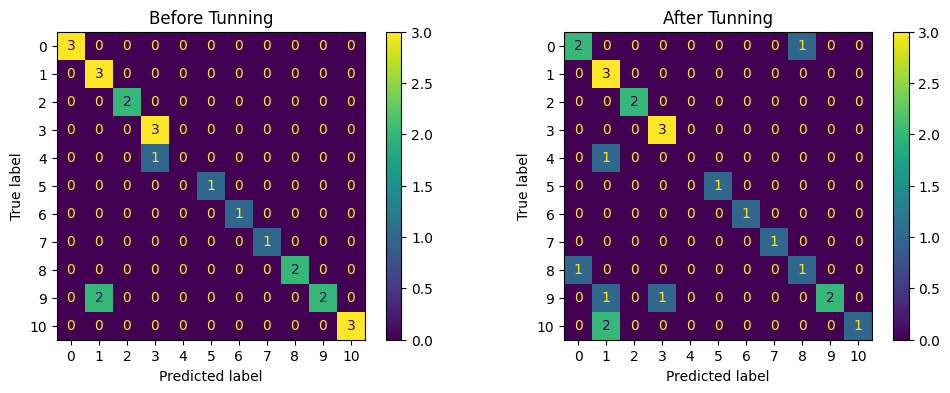

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

y_pred_t = best.predict(X_test)
cm_t = confusion_matrix(y_test, y_pred_t)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)
cm_display = ConfusionMatrixDisplay(cm_t).plot(ax=ax2)
ax1.title.set_text('Before Tunning')
ax2.title.set_text('After Tunning')

#Get Predict

In [ ]:
answer = pd.read_csv("/content/drive/MyDrive/answer - answer.csv")

In [ ]:
def get_predict(masukkan):
  masukkan = stem(stop_words(remove_punc(masukkan)))
  masukkan = vectorizer.transform([masukkan])
  predict = model.predict(masukkan)
  return le.inverse_transform(predict)[0]


In [ ]:
answer

,Greeting,Morning Greeting,Noon Greeting,Night Greeting,Goods List,Book Price,Buy Method,Promo method,Thankyou,Pencil Price,Features
0,Halo! Ada yang bisa saya bantu?,Selamat pagi! Ada yang bisa kami bantu?,Selamat siang! Ada yang bisa kami bantu?,Selamat malam! Ada yang bisa kami bantu?,Kami menjual beberapa barang seperti contohnya...,Kami menjual buku dengan harga 13000 per pak,"Untuk membeli barang tersebut, bisa dengan men...","Untuk saat ini, kami belum ada promo - promo",Terimakasih sudah menggunakan chatbot kami !,Kami menjual pensil dengan harga 2000 untuk sa...,Bot ini memiliki fitur untuk menyampaikan prom...
1,Halo !,Pagi juga ! Ada yang bisa saya bantu?,Siang juga ! Ada yang bisa saya bantu?,Malam juga ! Ada yang bisa Ada yang bisa saya ...,Toko ini menjual beberapa perlengkapan seperti...,Harga buku yang dijual di toko kami adalah seb...,Untuk melakukan transaksi bisa dengan mengunju...,"Sayang sekali, untuk promo masih belum ada, na...",Terimakasih juga sudah mau menggunakan chatbot...,Harga pensil yang kami jual sebesar 2000 per p...,Di sini kamu bisa bertanya tentang harga buku ...
2,"Hai, ada yang bisa dibantu?",Selamat pagi juga ! Ada yang bisa dibantu?,Selamat siangi juga ! Ada yang bisa dibantu?,Selamat malam juga ! Ada yang bisa dibantu?,Barang yang kami jual itu macam - macam sepert...,Buku yang kami jual sebesar 13 ribu per pak,Barang yang dijual bisa dibeli dengan mengunju...,"Untuk saat ini, kami belum memberikan promo, n...",Terima kasih kembali,Pensil yang kami jual sebesar 2000 per pensil,Bot ini memiliki fitur untuk menjawab pertanya...


In [ ]:
masukkan=""
while masukkan != "stop":
  masukkan = input("User: ")
  if masukkan != "stop":
    print("Chatbot: ", random.choice(answer[get_predict(masukkan)]))
  else:
    print("Terima kasih sudah bertanya!:D")

User: Pagi
Chatbot:  Selamat pagi! Ada yang bisa kami bantu?
User: Ada fitur apa ?
Chatbot:  Kami menjual beberapa barang seperti contohnya buku,pensil dan lain lainnya
User: berapa harga pensil?
Chatbot:  Harga pensil yang kami jual sebesar 2000 per pensil
User: lainnya ?
Chatbot:  Barang yang dijual bisa dibeli dengan mengunjungi toko terdekat, atau juga bisa kontak melalui social media kami
User: Terima kasih
Chatbot:  Barang yang dijual bisa dibeli dengan mengunjungi toko terdekat, atau juga bisa kontak melalui social media kami
User: terimakasih
Chatbot:  Terima kasih kembali
User: stop
Terima kasih sudah bertanya!:D


[Text(0.8571428571428571, 0.9545454545454546, 'x[49] <= 0.5\ngini = 0.9\nsamples = 93\nvalue = [10, 12, 9, 10, 4, 6, 6, 6, 7, 13, 10]'),
 Text(0.7857142857142857, 0.8636363636363636, 'x[16] <= 0.5\ngini = 0.896\nsamples = 82\nvalue = [10, 12, 9, 10, 4, 6, 6, 6, 7, 2, 10]'),
 Text(0.7142857142857143, 0.7727272727272727, 'x[14] <= 0.5\ngini = 0.884\nsamples = 72\nvalue = [0, 12, 9, 10, 4, 6, 6, 6, 7, 2, 10]'),
 Text(0.6428571428571429, 0.6818181818181818, 'x[2] <= 0.5\ngini = 0.869\nsamples = 63\nvalue = [0, 12, 0, 10, 4, 6, 6, 6, 7, 2, 10]'),
 Text(0.5, 0.5909090909090909, 'x[13] <= 0.5\ngini = 0.855\nsamples = 51\nvalue = [0, 10, 0, 0, 4, 6, 6, 6, 7, 2, 10]'),
 Text(0.42857142857142855, 0.5, 'x[55] <= 0.5\ngini = 0.831\nsamples = 44\nvalue = [0, 10, 0, 0, 4, 6, 6, 6, 0, 2, 10]'),
 Text(0.35714285714285715, 0.4090909090909091, 'x[36] <= 0.5\ngini = 0.798\nsamples = 38\nvalue = [0, 10, 0, 0, 4, 6, 6, 0, 0, 2, 10]'),
 Text(0.2857142857142857, 0.3181818181818182, 'x[45] <= 0.5\ngini = 0.75

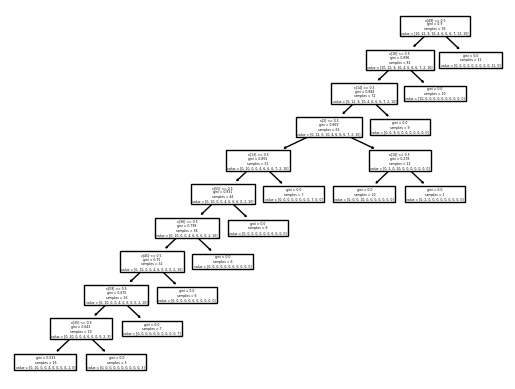

In [ ]:
tree.plot_tree(model)

In [ ]:
plt.figure()
plt.figure(figsize=(100,100))
plot_tree(model, filled=True)
plt.title("Decision tree")
plt.show()

<Figure size 640x480 with 0 Axes>